In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("/notebooks/JAXGym")

In [3]:
import jax
import jax.numpy as jnp

import flax
from flax import linen as nn  # Linen API
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax                           # Common loss functions and optimizers

from flax.training.train_state import TrainState

import gymnax
import brax

import matplotlib.pyplot as plt

In [4]:
from models.base_model import BaseModel, NormalDistPredictor, AffinedTanh
from models.base_q_estimator import BaseQEstimator

from agents.SAC import SAC

from samplers.sampler import Sampler

from off_policy_trainer import build_trainer

from structs import Buffer

from utils.callback import tqdm_callback

Tips in training SAC agent:

1. SAC agents typically required much more training steps (in total / per update) compared to PPO. Control the steps_per_update parameter.

In [5]:
action_limits = (-1, 1)

actor_lr = 1e-4
critic_lr = 1e-4

discount = 0.99

num_envs = 4

batch_size = 256
polyak_coef = 0.999
entropy_alpha = 0.2

iters = 200

max_episode_steps = 1000

steps_per_update = 1000

buffer_size_before_training = 10000

buffer_size = int(2e5)

env_name = "ant"
backend = "positional"

In [6]:
# https://github.com/luchris429/purejaxrl/blob/5343613b07b3bc543c49695df601fc40f5ec3062/purejaxrl/wrappers.py#L117

from gymnax.environments import environment, spaces
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper

class BraxGymnaxWrapper:
    def __init__(self, env_name, backend="positional"):
        env = envs.get_environment(env_name=env_name, backend=backend)
        env = EpisodeWrapper(env, episode_length=1000, action_repeat=1)
        env = AutoResetWrapper(env)
        self._env = env
        self.action_size = env.action_size
        self.observation_size = (env.observation_size,)

    def reset(self, key, params=None):
        state = self._env.reset(key)
        return state.obs, state

    def step(self, key, state, action, params=None):
        next_state = self._env.step(state, action)
        return next_state.obs, next_state, next_state.reward, next_state.done > 0.5, {}

    def observation_space(self, params):
        return spaces.Box(
            low=-jnp.inf,
            high=jnp.inf,
            shape=(self._env.observation_size,),
        )

    def action_space(self, params):
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self._env.action_size,),
        )

In [7]:
from brax import envs

env, env_params = BraxGymnaxWrapper(env_name), None

obs_size = env.observation_space(env_params).shape[0]
action_size = env.action_space(env_params).shape[0]

In [8]:
cpu_device = jax.devices('cpu')[0]
gpu_device = jax.devices('gpu')[0]

with jax.default_device(gpu_device):
    key = jax.random.PRNGKey(64)
    
    dummy = jnp.ones([1, obs_size])
    action_dummy = jnp.ones([1, action_size])
    actor_init_key, critic_init_key, key = jax.random.split(key, 3)
    
    actor_model = nn.Sequential([BaseModel(hidden_size = 128, num_layers = 2), NormalDistPredictor(output_size = action_size, limits = action_limits)])
    actor_params = actor_model.init(actor_init_key, dummy)['params']
    actor_tx = optax.chain(
       optax.clip_by_global_norm(1),
       optax.adam(actor_lr),
    )
    actor = TrainState.create(apply_fn=actor_model.apply,
                              params=actor_params,
                              tx=actor_tx,
                              )
    
    critic_model = nn.Sequential([BaseQEstimator(hidden_size = 128, num_layers = 2), nn.Dense(features = 1)])

    critic_init_key_1, critic_init_key_2 = jax.random.split(critic_init_key, 2)
    critic_params_1 = critic_model.init(critic_init_key_1, dummy, action_dummy)['params']
    critic_tx_1 = optax.chain(
       optax.clip_by_global_norm(1),
       optax.adam(critic_lr),
    )
    critic_1 = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params_1,
                              tx=critic_tx_1,
                              )

    critic_params_2 = critic_model.init(critic_init_key_2, dummy, action_dummy)['params']
    critic_tx_2 = optax.chain(
       optax.clip_by_global_norm(1),
       optax.adam(critic_lr),
    )
    critic_2 = TrainState.create(apply_fn=critic_model.apply,
                              params=critic_params_2,
                              tx=critic_tx_2,
                              )
    
    agent = SAC(discount, polyak_coef, entropy_alpha, action_limits)
    
    buffer = Buffer(
        jnp.zeros((num_envs, buffer_size, obs_size)),
        jnp.zeros((num_envs, buffer_size, 1)),
        jnp.zeros((num_envs, buffer_size, action_size)),
        jnp.zeros((num_envs, buffer_size, 1)),
        jnp.zeros((buffer_size,)),
        0
    )

    sampler = Sampler(batch_size)
    
    logger = jnp.zeros((iters, 1))

    fori_body = build_trainer(agent, sampler, env, env_params, num_envs, obs_size, action_size, max_episode_steps, buffer_size_before_training, steps_per_update, tqdm_callback(iters))
    
    carry = (actor, (critic_1, critic_2), None, (critic_1.params, critic_2.params), buffer, logger, key)
    carry = jax.lax.fori_loop(0, iters, fori_body, carry)

100%|██████████| 200/200 [12:37<00:00,  3.74s/it, Reward=9.0166645]  

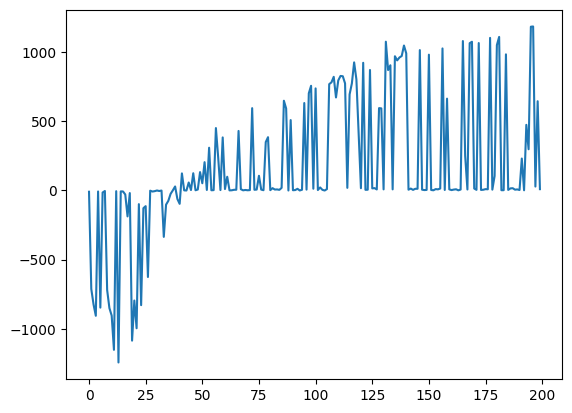

In [11]:
plt.clf()
plt.gca().set_aspect('auto')
plt.plot(carry[-2][:])
plt.show()

In [12]:
from IPython.display import HTML

from brax.io import html
from tqdm.notebook import tqdm

actor = carry[0]

env = envs.create(env_name=env_name, backend=backend)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(lambda obs: agent.suggest_action(obs, actor))

done = 0

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in tqdm(range(500)):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act = jit_inference_fn(state.obs)
    state = jit_env_step(state, act)

    if state.done > 0.5:
        print(_)
        done += 1

HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollout))

  0%|          | 0/500 [00:00<?, ?it/s]